<a href="https://colab.research.google.com/github/afrin764/aav_Supervised_and_semi_supervised/blob/main/100_4sFeature_extraction_clissifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Training ResNet50_SVM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 556 images belonging to 3 classes.
Found 137 images belonging to 3 classes.
94765736/94765736 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 0us/step

Processing with ResNet50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 153s 8s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 34s 7s/step

Training ResNet50_SVM
Classification Report:
              precision    recall  f1-score   support

      Double       0.82      0.96      0.89        53
       Empty       0.79      0.87      0.83        30
      Single       0.90      0.70      0.79        54

    accuracy                           0.84       137
   macro avg       0.84      0.84      0.83       137
weighted avg       0.85      0.84      0.84       137

Confusion Matrix:
[[51  1  1]
 [ 1 26  3]
 [10  6 38]]


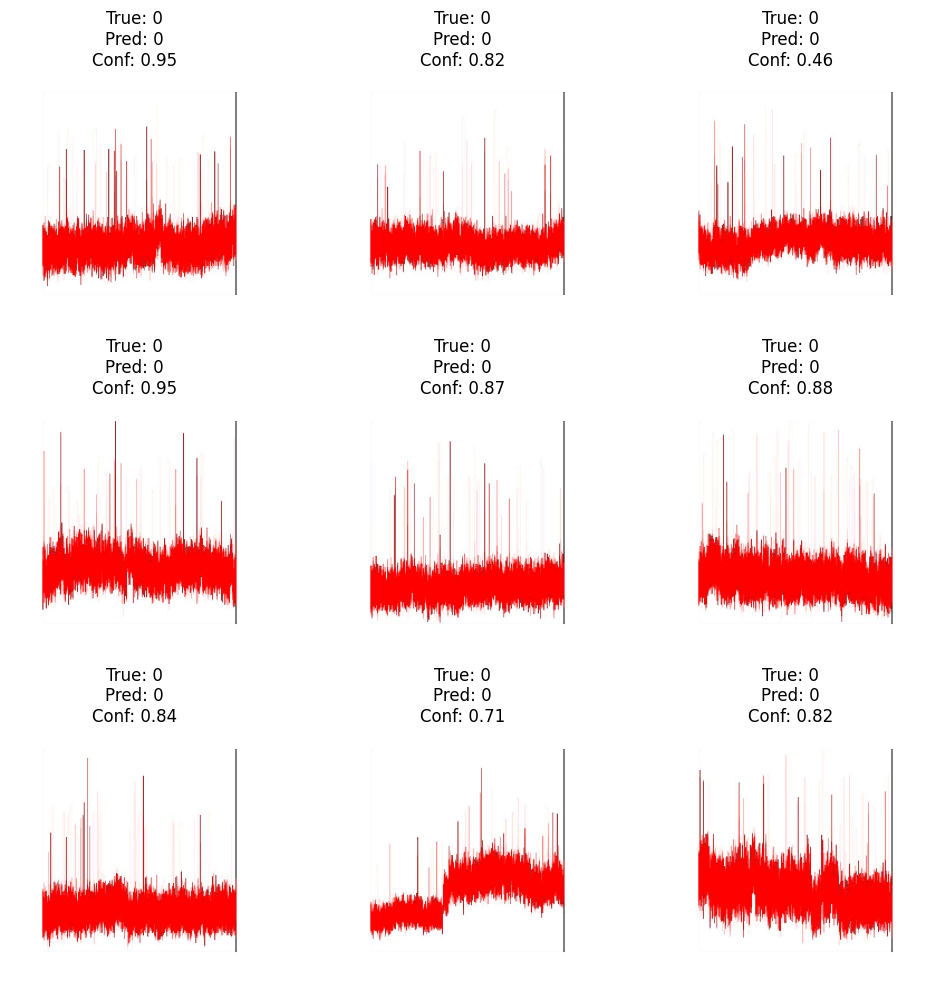

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive

drive.mount('/content/drive')

# Define dataset paths
train_dir = "/content/drive/MyDrive/100_4strain_val_photos"

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data preprocessing & augmentation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=False)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False)

# Load Pretrained Models
models = {
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg'),
    #'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg'),
    #'MobileNetV3': MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
}

# Extract features from dataset
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(train_generator.classes)

# Loop over each model and classifier
for model_name, model in models.items():
    print(f"\nProcessing with {model_name}")

    train_features, train_labels = extract_features(train_generator, model)
    val_features, val_labels = extract_features(val_generator, model)

    train_labels = label_encoder.transform(train_labels)
    val_labels = label_encoder.transform(val_labels)

    classifiers = {
        f'{model_name}_SVM': SVC(kernel='linear', probability=True),
       # f'{model_name}_MLP': MLPClassifier(hidden_layer_sizes=(256,), max_iter=500),
        #f'{model_name}_NaiveBayes': GaussianNB()
    }

    for clf_name, clf in classifiers.items():
        print(f"\nTraining {clf_name}")

        clf.fit(train_features, train_labels)
        val_predictions = clf.predict(val_features)
        val_probabilities = clf.predict_proba(val_features)

        print("Classification Report:")
        print(classification_report(val_labels, val_predictions, target_names=train_generator.class_indices.keys()))

        print("Confusion Matrix:")
        print(confusion_matrix(val_labels, val_predictions))

        # Visualize predictions
        fig, axes = plt.subplots(3, 3, figsize=(10, 10))
        for i, ax in enumerate(axes.flat):
            idx = i % len(val_generator.filenames)
            img_path = os.path.join(val_generator.directory, val_generator.filenames[idx])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0

            true_label = val_labels[idx]
            pred_label = val_predictions[idx]
            confidence = np.max(val_probabilities[idx])

            ax.imshow(img)
            ax.set_title(f'True: {label_encoder.inverse_transform([true_label])[0]}\nPred: {label_encoder.inverse_transform([pred_label])[0]}\nConf: {confidence:.2f}')
            ax.axis('off')

        plt.tight_layout()
        plt.show()


In [ ]:
Training ResNet50_MLP

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 556 images belonging to 3 classes.
Found 137 images belonging to 3 classes.

Processing with ResNet50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 112s 6s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 5s/step

Training ResNet50_MLP
Classification Report:
              precision    recall  f1-score   support

      Double       0.71      0.98      0.83        53
       Empty       0.76      0.83      0.79        30
      Single       1.00      0.57      0.73        54

    accuracy                           0.79       137
   macro avg       0.82      0.80      0.78       137
weighted avg       0.84      0.79      0.78       137

Confusion Matrix:
[[52  1  0]
 [ 5 25  0]
 [16  7 31]]


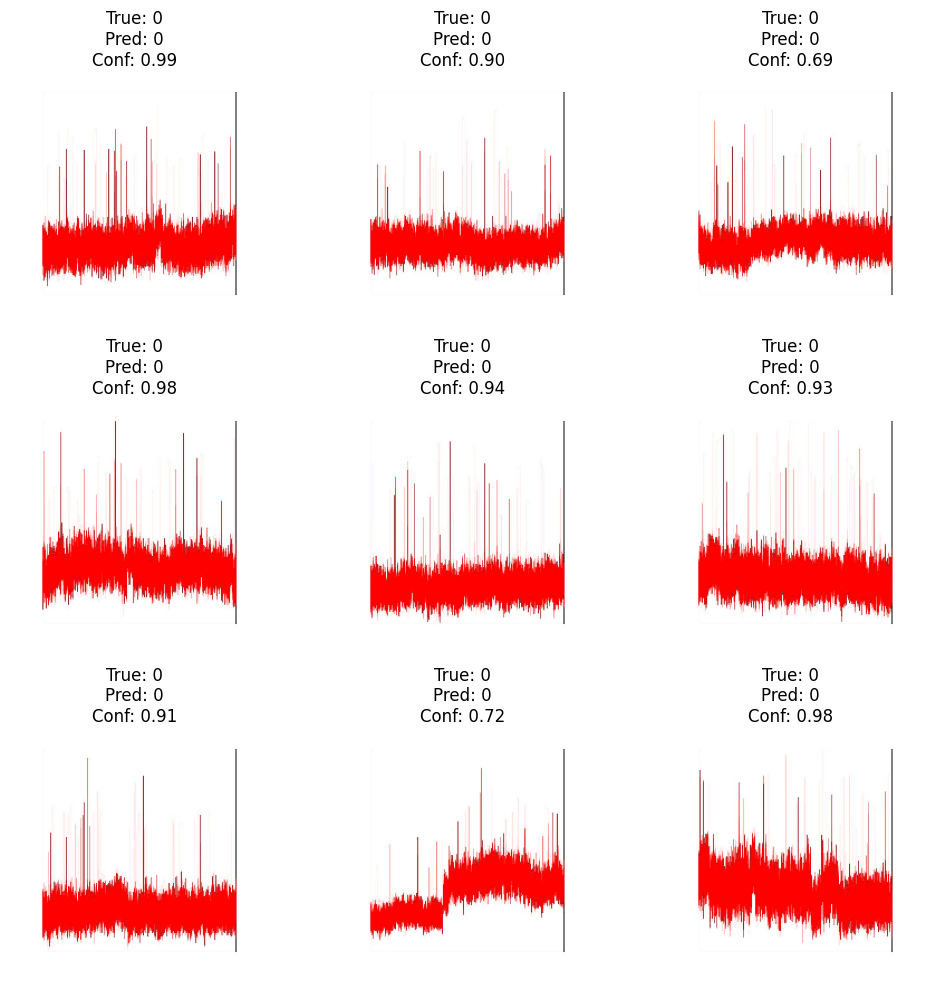

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive

drive.mount('/content/drive')

# Define dataset paths
train_dir = "/content/drive/MyDrive/100_4strain_val_photos"

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data preprocessing & augmentation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=False)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False)

# Load Pretrained Models
models = {
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg'),
    #'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg'),
    #'MobileNetV3': MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
}

# Extract features from dataset
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(train_generator.classes)

# Loop over each model and classifier
for model_name, model in models.items():
    print(f"\nProcessing with {model_name}")

    train_features, train_labels = extract_features(train_generator, model)
    val_features, val_labels = extract_features(val_generator, model)

    train_labels = label_encoder.transform(train_labels)
    val_labels = label_encoder.transform(val_labels)

    classifiers = {
        #f'{model_name}_SVM': SVC(kernel='linear', probability=True),
        f'{model_name}_MLP': MLPClassifier(hidden_layer_sizes=(256,), max_iter=500),
        #f'{model_name}_NaiveBayes': GaussianNB()
    }

    for clf_name, clf in classifiers.items():
        print(f"\nTraining {clf_name}")

        clf.fit(train_features, train_labels)
        val_predictions = clf.predict(val_features)
        val_probabilities = clf.predict_proba(val_features)

        print("Classification Report:")
        print(classification_report(val_labels, val_predictions, target_names=train_generator.class_indices.keys()))

        print("Confusion Matrix:")
        print(confusion_matrix(val_labels, val_predictions))

        # Visualize predictions
        fig, axes = plt.subplots(3, 3, figsize=(10, 10))
        for i, ax in enumerate(axes.flat):
            idx = i % len(val_generator.filenames)
            img_path = os.path.join(val_generator.directory, val_generator.filenames[idx])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0

            true_label = val_labels[idx]
            pred_label = val_predictions[idx]
            confidence = np.max(val_probabilities[idx])

            ax.imshow(img)
            ax.set_title(f'True: {label_encoder.inverse_transform([true_label])[0]}\nPred: {label_encoder.inverse_transform([pred_label])[0]}\nConf: {confidence:.2f}')
            ax.axis('off')

        plt.tight_layout()
        plt.show()


In [ ]:
ResNet50_NaiveBayes

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 556 images belonging to 3 classes.
Found 137 images belonging to 3 classes.

Processing with ResNet50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 114s 6s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 26s 5s/step

Training ResNet50_NaiveBayes
Classification Report:
              precision    recall  f1-score   support

      Double       0.51      0.70      0.59        53
       Empty       0.49      0.87      0.63        30
      Single       0.58      0.13      0.21        54

    accuracy                           0.51       137
   macro avg       0.53      0.56      0.48       137
weighted avg       0.54      0.51      0.45       137

Confusion Matrix:
[[37 12  4]
 [ 3 26  1]
 [32 15  7]]


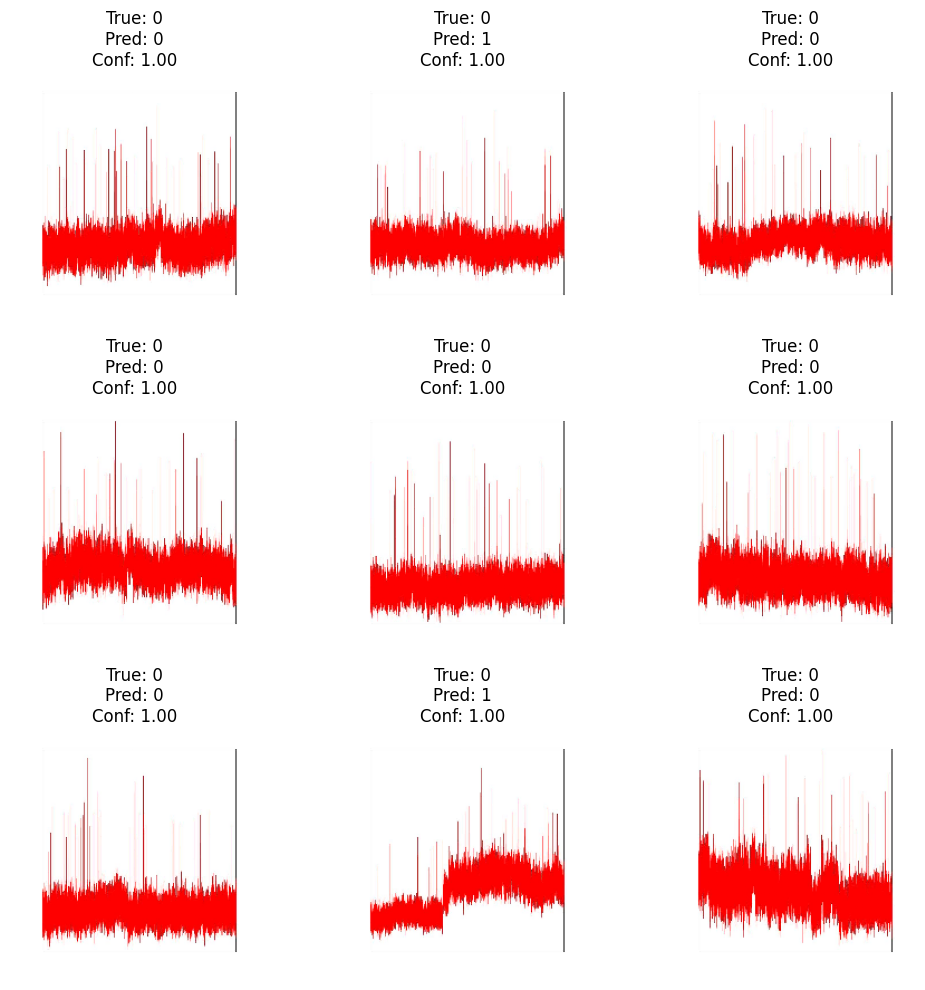

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive

drive.mount('/content/drive')

# Define dataset paths
train_dir = "/content/drive/MyDrive/100_4strain_val_photos"

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data preprocessing & augmentation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=False)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False)

# Load Pretrained Models
models = {
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg'),
    #'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg'),
    #'MobileNetV3': MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
}

# Extract features from dataset
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(train_generator.classes)

# Loop over each model and classifier
for model_name, model in models.items():
    print(f"\nProcessing with {model_name}")

    train_features, train_labels = extract_features(train_generator, model)
    val_features, val_labels = extract_features(val_generator, model)

    train_labels = label_encoder.transform(train_labels)
    val_labels = label_encoder.transform(val_labels)

    classifiers = {
        #f'{model_name}_SVM': SVC(kernel='linear', probability=True),
        #f'{model_name}_MLP': MLPClassifier(hidden_layer_sizes=(256,), max_iter=500),
        f'{model_name}_NaiveBayes': GaussianNB()
    }

    for clf_name, clf in classifiers.items():
        print(f"\nTraining {clf_name}")

        clf.fit(train_features, train_labels)
        val_predictions = clf.predict(val_features)
        val_probabilities = clf.predict_proba(val_features)

        print("Classification Report:")
        print(classification_report(val_labels, val_predictions, target_names=train_generator.class_indices.keys()))

        print("Confusion Matrix:")
        print(confusion_matrix(val_labels, val_predictions))

        # Visualize predictions
        fig, axes = plt.subplots(3, 3, figsize=(10, 10))
        for i, ax in enumerate(axes.flat):
            idx = i % len(val_generator.filenames)
            img_path = os.path.join(val_generator.directory, val_generator.filenames[idx])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0

            true_label = val_labels[idx]
            pred_label = val_predictions[idx]
            confidence = np.max(val_probabilities[idx])

            ax.imshow(img)
            ax.set_title(f'True: {label_encoder.inverse_transform([true_label])[0]}\nPred: {label_encoder.inverse_transform([pred_label])[0]}\nConf: {confidence:.2f}')
            ax.axis('off')

        plt.tight_layout()
        plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 556 images belonging to 3 classes.
Found 137 images belonging to 3 classes.
12683000/12683000 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step

Processing with MobileNetV3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 25s 1s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 822ms/step

Training MobileNetV3_NaiveBayes
Classification Report:
              precision    recall  f1-score   support

      Double       0.43      0.87      0.57        53
       Empty       0.62      0.43      0.51        30
      Single       0.12      0.02      0.03        54

    accuracy                           0.44       137
   macro avg       0.39      0.44      0.37       137
weighted avg       0.35      0.44      0.35       137

Confusion Matrix:
[[46  0  7]
 [17 13  0]
 [45  8  1]]


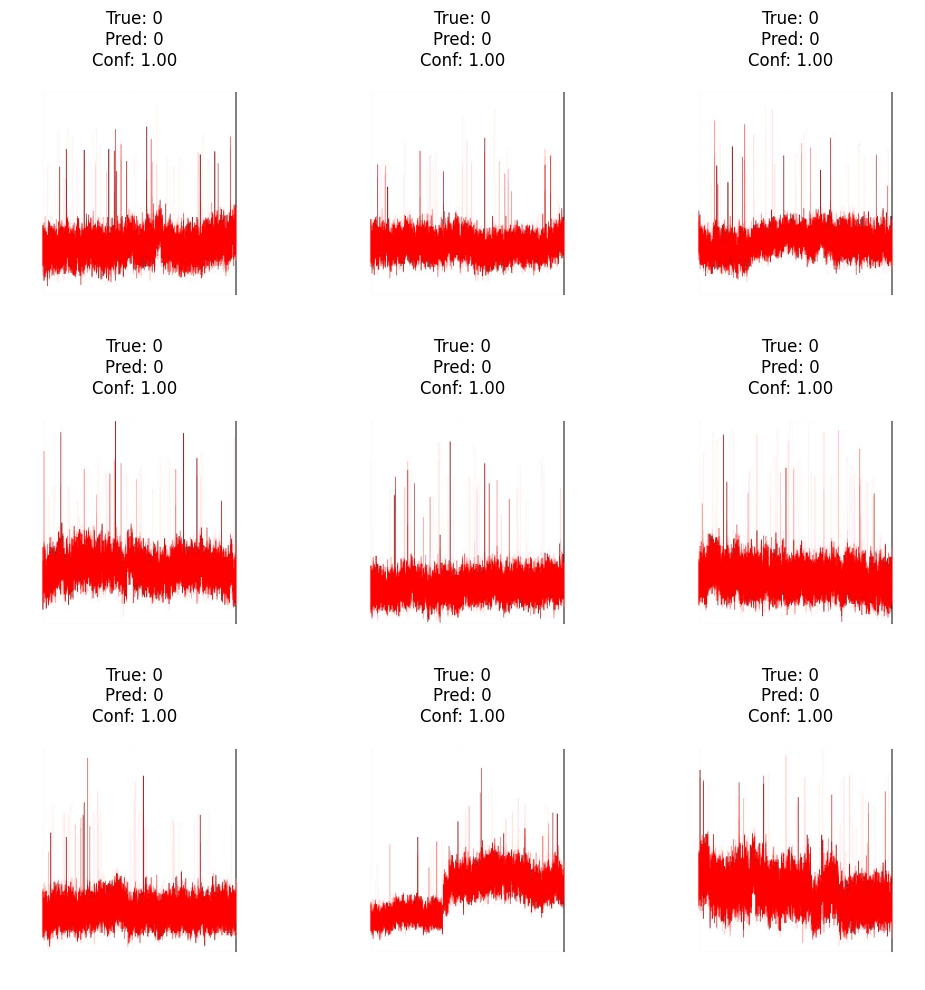

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive

drive.mount('/content/drive')

# Define dataset paths
train_dir = "/content/drive/MyDrive/100_4strain_val_photos"

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data preprocessing & augmentation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=False)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False)

# Load Pretrained Models
models = {
    #'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg'),
    #'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg'),
    'MobileNetV3': MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
}

# Extract features from dataset
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(train_generator.classes)

# Loop over each model and classifier
for model_name, model in models.items():
    print(f"\nProcessing with {model_name}")

    train_features, train_labels = extract_features(train_generator, model)
    val_features, val_labels = extract_features(val_generator, model)

    train_labels = label_encoder.transform(train_labels)
    val_labels = label_encoder.transform(val_labels)

    classifiers = {
        #f'{model_name}_SVM': SVC(kernel='linear', probability=True),
        #f'{model_name}_MLP': MLPClassifier(hidden_layer_sizes=(256,), max_iter=500),
        f'{model_name}_NaiveBayes': GaussianNB()
    }

    for clf_name, clf in classifiers.items():
        print(f"\nTraining {clf_name}")

        clf.fit(train_features, train_labels)
        val_predictions = clf.predict(val_features)
        val_probabilities = clf.predict_proba(val_features)

        print("Classification Report:")
        print(classification_report(val_labels, val_predictions, target_names=train_generator.class_indices.keys()))

        print("Confusion Matrix:")
        print(confusion_matrix(val_labels, val_predictions))

        # Visualize predictions
        fig, axes = plt.subplots(3, 3, figsize=(10, 10))
        for i, ax in enumerate(axes.flat):
            idx = i % len(val_generator.filenames)
            img_path = os.path.join(val_generator.directory, val_generator.filenames[idx])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0

            true_label = val_labels[idx]
            pred_label = val_predictions[idx]
            confidence = np.max(val_probabilities[idx])

            ax.imshow(img)
            ax.set_title(f'True: {label_encoder.inverse_transform([true_label])[0]}\nPred: {label_encoder.inverse_transform([pred_label])[0]}\nConf: {confidence:.2f}')
            ax.axis('off')

        plt.tight_layout()
        plt.show()


In [ ]:
28/06/2025

Found 556 images belonging to 3 classes.
Found 137 images belonging to 3 classes.
94765736/94765736 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step
Extracting training features...
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 10s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 5s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 5s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 6s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 7s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 8s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 7s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 6s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 5s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 6s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

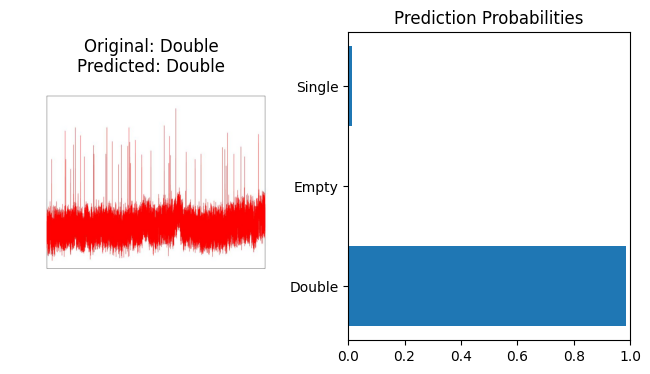

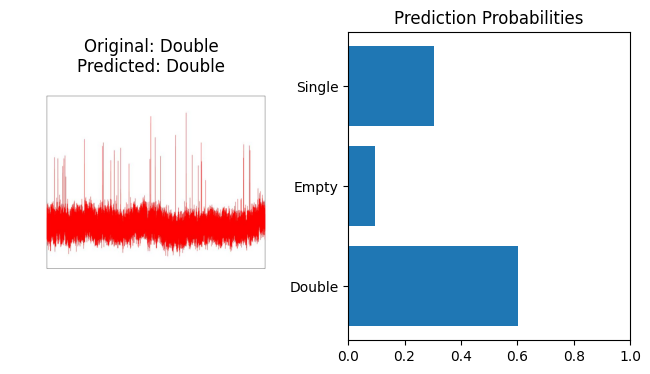

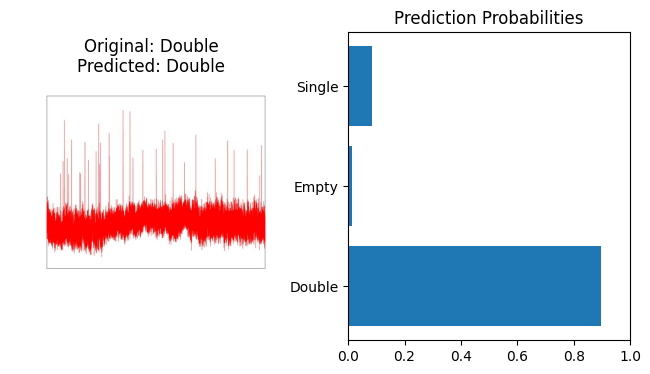

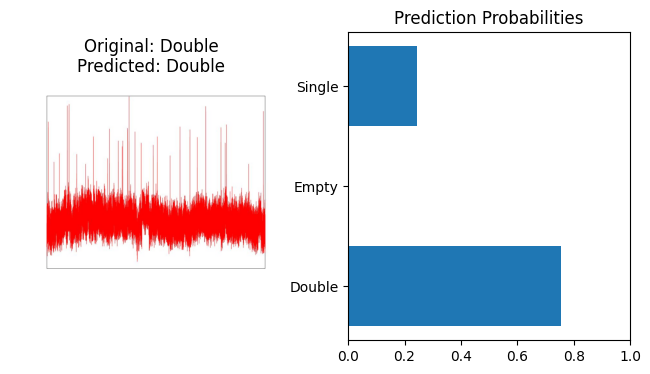

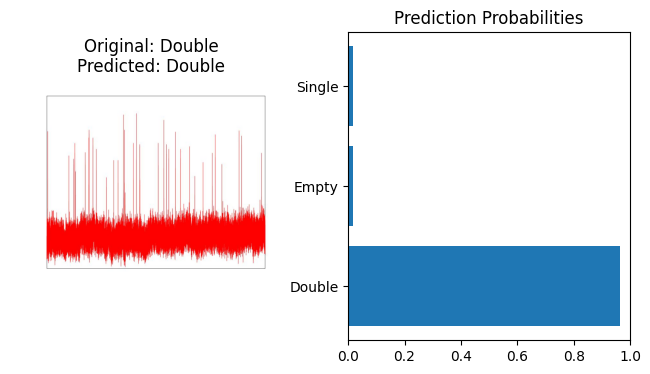

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import joblib  # to save/load model
from PIL import Image

# --- Configurations ---
image_folder = r'/content/drive/MyDrive/100_4strain_val_photos'
image_size = (224, 224)
batch_size = 32

# --- Load dataset with Keras ImageDataGenerator ---
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    image_folder,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    image_folder,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# --- Load pretrained ResNet50 without top layers ---
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add global average pooling to get feature vectors
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Sequential

model = Sequential([
    base_model,
    GlobalAveragePooling2D()
])

# --- Extract features for training set ---
def extract_features(generator):
    features = []
    labels = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        feats = model.predict(x_batch)
        features.append(feats)
        labels.append(y_batch)
    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, labels

print("Extracting training features...")
train_features, train_labels = extract_features(train_generator)

print("Extracting validation features...")
val_features, val_labels = extract_features(val_generator)

# Convert one-hot labels to class indices
train_labels_idx = np.argmax(train_labels, axis=1)
val_labels_idx = np.argmax(val_labels, axis=1)

# Encode class labels (in case class names are strings)
label_encoder = LabelEncoder()
train_classes = label_encoder.fit_transform(train_generator.classes)
val_classes = label_encoder.transform(val_generator.classes)

# --- Train SVM classifier ---
print("Training SVM classifier...")
svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(train_features, train_labels_idx)

# --- Evaluate on validation set ---
val_preds = svm_classifier.predict(val_features)
val_probs = svm_classifier.predict_proba(val_features)

print(classification_report(val_labels_idx, val_preds, target_names=train_generator.class_indices.keys()))

# --- Save prediction details to files ---
num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())

# Prepare files for each class
file_handles = {}
for cls in class_names:
    f = open(f"{cls}.dat", "w")
    f.write('Original_label  Predicted_label  ' + '  '.join([f'p_of_{c}' for c in class_names]) + '\n')
    file_handles[cls] = f

for i in range(len(val_labels_idx)):
    orig_label = class_names[val_labels_idx[i]]
    pred_label = class_names[val_preds[i]]
    probs = val_probs[i]
    # Write to corresponding file for original label
    fh = file_handles[orig_label]
    line = f"{orig_label:15} {pred_label:15} " + "  ".join([f"{p:.3f}" for p in probs]) + "\n"
    fh.write(line)

# Close all files
for fh in file_handles.values():
    fh.close()

# --- Optional: Visualize predictions for first few images ---
for i in range(5):
    img_path = val_generator.filepaths[i]
    img = Image.open(img_path)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Original: {class_names[val_labels_idx[i]]}\nPredicted: {class_names[val_preds[i]]}")

    plt.subplot(1,2,2)
    plt.barh(class_names, val_probs[i])
    plt.xlim(0,1)
    plt.title("Prediction Probabilities")
    plt.show()


Found 556 images belonging to 3 classes.
Found 137 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 113s 6s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 5s/step

üîµ Training SVM...
‚úÖ SVM Accuracy: 32.12%
              precision    recall  f1-score   support

      Double       0.28      0.26      0.27        53
       Empty       0.18      0.20      0.19        30
      Single       0.45      0.44      0.45        54

    accuracy                           0.32       137
   macro avg       0.30      0.30      0.30       137
weighted avg       0.33      0.32      0.32       137



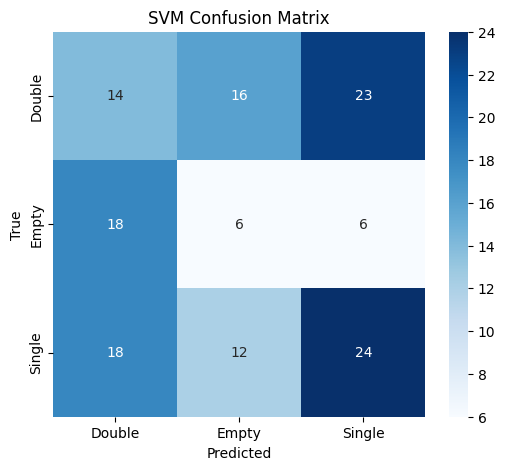

üíæ Saved predictions to Predictions_SVM.csv

üîµ Training Naive_Bayes...
‚úÖ Naive_Bayes Accuracy: 38.69%
              precision    recall  f1-score   support

      Double       0.49      0.40      0.44        53
       Empty       0.14      0.10      0.12        30
      Single       0.40      0.54      0.46        54

    accuracy                           0.39       137
   macro avg       0.34      0.34      0.34       137
weighted avg       0.38      0.39      0.38       137



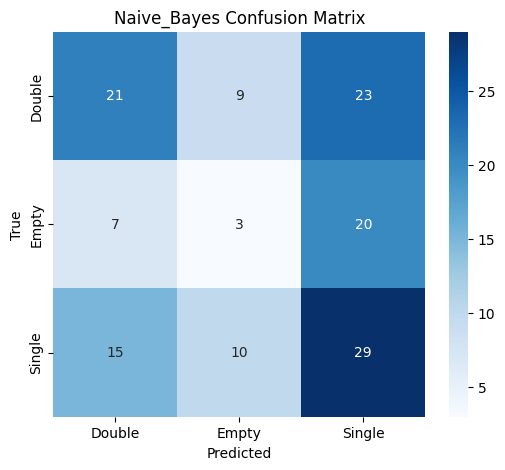

üíæ Saved predictions to Predictions_Naive_Bayes.csv

üîµ Training MLP...
‚úÖ MLP Accuracy: 41.61%
              precision    recall  f1-score   support

      Double       0.44      0.43      0.44        53
       Empty       0.15      0.13      0.14        30
      Single       0.52      0.56      0.54        54

    accuracy                           0.42       137
   macro avg       0.37      0.37      0.37       137
weighted avg       0.41      0.42      0.41       137



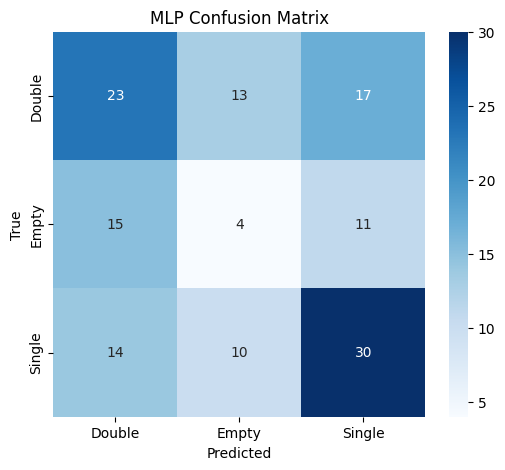

üíæ Saved predictions to Predictions_MLP.csv

üîµ Training Random_Forest...
‚úÖ Random_Forest Accuracy: 42.34%
              precision    recall  f1-score   support

      Double       0.40      0.51      0.45        53
       Empty       0.00      0.00      0.00        30
      Single       0.46      0.57      0.51        54

    accuracy                           0.42       137
   macro avg       0.29      0.36      0.32       137
weighted avg       0.34      0.42      0.38       137



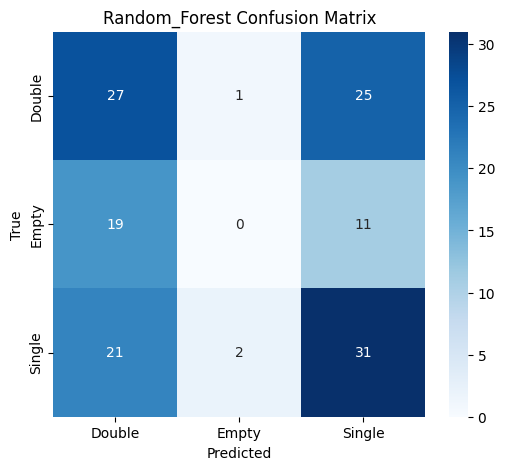

üíæ Saved predictions to Predictions_Random_Forest.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ‚úÖ Dataset Path (from Google Drive)
image_folder = '/content/drive/MyDrive/100_4strain_val_photos'  # Change accordingly

# ‚úÖ Data Preprocessing
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    image_folder,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    image_folder,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ‚úÖ Load Pre-trained ResNet50 (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

# ‚úÖ Feature Extraction Function
def extract_features(generator):
    features = base_model.predict(generator, verbose=1)
    labels = generator.classes
    class_names = list(generator.class_indices.keys())
    return features, labels, class_names

train_features, train_labels, class_names = extract_features(train_gen)
val_features, val_labels, _ = extract_features(val_gen)

# ‚úÖ Classifiers to Apply
classifiers = {
    'SVM': SVC(kernel='linear', probability=True),
    'Naive_Bayes': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500),
    'Random_Forest': RandomForestClassifier(n_estimators=100)
}

results = {}

for name, clf in classifiers.items():
    print(f"\nüîµ Training {name}...")
    clf.fit(train_features, train_labels)
    preds = clf.predict(val_features)
    probs = clf.predict_proba(val_features)

    acc = accuracy_score(val_labels, preds)
    cm = confusion_matrix(val_labels, preds)

    print(f"‚úÖ {name} Accuracy: {acc * 100:.2f}%")
    print(classification_report(val_labels, preds, target_names=class_names))

    results[name] = {
        'accuracy': acc,
        'confusion_matrix': cm,
        'predictions': preds,
        'probabilities': probs
    }

    # üé® Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # üìù Save Predictions
    df = pd.DataFrame(probs, columns=class_names)
    df['Original_Label'] = [class_names[i] for i in val_labels]
    df['Predicted_Label'] = [class_names[i] for i in preds]
    df.to_csv(f'Predictions_{name}.csv', index=False)
    print(f"üíæ Saved predictions to Predictions_{name}.csv")



In [ ]:
# Install Libraries
!pip install tensorflow scikit-learn opencv-python matplotlib

# Import Libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV3Large
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.models import Model

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Dataset Path
dataset_path = '/content/drive/MyDrive/100_4strain_val_photos'  # Change this

# Load Dataset
img_size = (224, 224)
X, y = [], []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            label = os.path.basename(root)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)
print("Total images:", len(X))
print("Classes:", np.unique(y))

# Preprocess & Split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Feature Extraction Function
def extract_features(model_name, X_data):
    if model_name == 'resnet':
        base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
        X_data = resnet_preprocess(X_data.copy())
    elif model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
        X_data = vgg_preprocess(X_data.copy())
    elif model_name == 'mobilenet':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, pooling='avg')
        X_data = mobilenet_preprocess(X_data.copy())
    else:
        raise ValueError("Invalid model name")
    model = Model(inputs=base_model.input, outputs=base_model.output)
    features = model.predict(X_data, batch_size=32, verbose=1)
    return features

# Loop over feature extractors
feature_extractors = ['resnet', 'vgg16', 'mobilenet']
results_all = []

for model_choice in feature_extractors:
    print(f"\nExtracting features using {model_choice.upper()}...")
    train_features = extract_features(model_choice, X_train)
    val_features = extract_features(model_choice, X_val)

    # Classifiers
    classifiers = {
        "SVM": SVC(kernel='linear', probability=True),
        "MLP": MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500),
        "KNN": KNeighborsClassifier(n_neighbors=3),
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
    }

    for clf_name, clf in classifiers.items():
        print(f"\nTraining {clf_name} with {model_choice.upper()} features...")
        clf.fit(train_features, y_train)
        y_pred = clf.predict(val_features)
        acc = accuracy_score(y_val, y_pred)
        cm = confusion_matrix(y_val, y_pred)
        print(f"{clf_name} Accuracy: {acc*100:.2f}%")
        print("Confusion Matrix:\n", cm)

        results_all.append({
            'FeatureExtractor': model_choice.upper(),
            'Classifier': clf_name,
            'Accuracy': acc,
            'ConfusionMatrix': cm
        })

# Save results
result_df = pd.DataFrame([{
    'FeatureExtractor': r['FeatureExtractor'],
    'Classifier': r['Classifier'],
    'Accuracy (%)': round(r['Accuracy']*100, 2)
} for r in results_all])

save_path = '/content/drive/MyDrive/classifier_results.csv'
result_df.to_csv(save_path, index=False)
print(f"\nResults saved to {save_path}")

# Display Results
print("\nSummary Results:\n", result_df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images: 693
Classes: ['Double' 'Empty' 'Single']

Extracting features using RESNET...
18/18 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 124s 7s/step
5/5 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 33s 6s/step

Training SVM with RESNET features...
SVM Accuracy: 89.21%
Confusion Matrix:
 [[48  3  2]
 [ 4 25  2]
 [ 3  1 51]]

Training MLP with RESNET features...
MLP Accuracy: 91.37%
Confusion Matrix:
 [[48  3  2]
 [ 2 26  3]
 [ 2  0 53]]

Training KNN with RESNET features...
KNN Accuracy: 83.45%
Confusion Matrix:
 [[47  4  2]
 [ 7 22  2]
 [ 7  1 47]]

Training RandomForest with RESNET features...
RandomForest Accuracy: 85.61%
Confusion Matrix:
 [[44  2  7]
 [ 3 24  4]
 [ 4  0 51]]

Extracting features using VGG16...
58889256/58889256 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step


18/18 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 328s 18s/step
5/5 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 92s 18s/step

Training SVM with VGG16 features...
SVM Accuracy: 85.61%
Confusion Matrix:
 [[48  1  4]
 [ 7 21  3]
 [ 4  1 50]]

Training MLP with VGG16 features...
MLP Accuracy: 89.93%
Confusion Matrix:
 [[49  2  2]
 [ 5 25  1]
 [ 3  1 51]]

Training KNN with VGG16 features...
KNN Accuracy: 81.29%
Confusion Matrix:
 [[44  3  6]
 [ 4 24  3]
 [ 8  2 45]]

Training RandomForest with VGG16 features...
RandomForest Accuracy: 82.73%
Confusion Matrix:
 [[44  4  5]
 [ 5 23  3]
 [ 5  2 48]]

Extracting features using MOBILENET...


/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step


18/18 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 1s/step


/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


5/5 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 2s/step

Training SVM with MOBILENET features...
SVM Accuracy: 90.65%
Confusion Matrix:
 [[49  0  4]
 [ 2 26  3]
 [ 2  2 51]]

Training MLP with MOBILENET features...
MLP Accuracy: 89.21%
Confusion Matrix:
 [[49  1  3]
 [ 4 25  2]
 [ 3  2 50]]

Training KNN with MOBILENET features...
KNN Accuracy: 84.17%
Confusion Matrix:
 [[44  3  6]
 [ 4 25  2]
 [ 5  2 48]]

Training RandomForest with MOBILENET features...
RandomForest Accuracy: 80.58%
Confusion Matrix:
 [[42  4  7]
 [ 7 20  4]
 [ 3  2 50]]

Results saved to /content/drive/MyDrive/classifier_results.csv

Summary Results:
    FeatureExtractor    Classifier  Accuracy (%)
0            RESNET           SVM         89.21
1            RESNET           MLP         91.37
2            RESNET           KNN         83.45
3            RESNET  RandomForest         85.61
4             VGG16           SVM         85.61
5             VGG16           MLP         89.93
6             

In [ ]:
!pip install matplotlib-venn

In [ ]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [ ]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 126308 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.6.0-1ubuntu1.5_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.6.0-1ubuntu1.5) ...
Setting up libarchive-dev:amd64 (3.6.0-1ubuntu1.5) ...
Processing triggers for man-db (2.10.2-1) ...
  Preparing metadata (setup.py) ... done
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 154.7/154.7 kB 5.1 MB/s eta 0:00:00
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31629 sha256=522b16b6cdd50a57b8c9593f98378ce2404947d018e8d35c8716c2e132d858f2
  Stored in directory: /root/.cache/pip/wheels/32/98/bd/4893d6923dd027f455b250367d402bfd69a6f4416581df46db
Successfully built libarchive


In [ ]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

In [ ]:
!pip install cartopy
import cartopy

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11.7/11.7 MB 47.5 MB/s eta 0:00:00


In [ ]:
!pip install transformers


In [ ]:
!pip install tensorflow==2.12 tensorflow-addons==0.21 vit-keras==0.1.2


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images: 693
Classes: ['Double' 'Empty' 'Single']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


Extracting features using RESNET...
5/5 [==============================] - 30s 5s/step

Training SVM with RESNET features...
SVM Accuracy: 89.21%
‚úÖ Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/RESNET_SVM_confusion_matrix.png


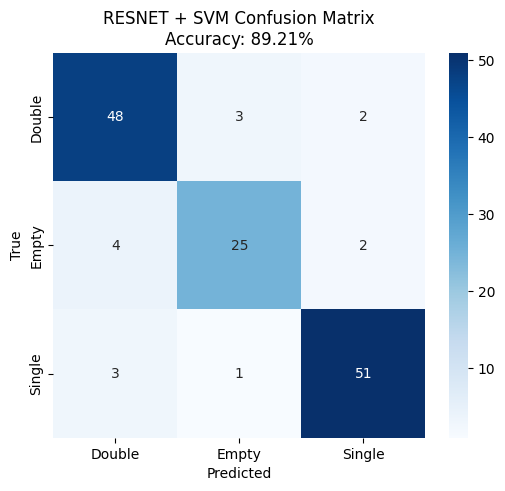


Training MLP with RESNET features...
MLP Accuracy: 91.37%
‚úÖ Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/RESNET_MLP_confusion_matrix.png


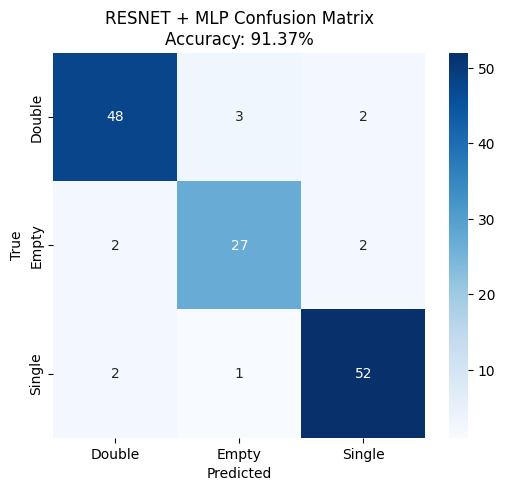


Training RandomForest with RESNET features...
RandomForest Accuracy: 85.61%
‚úÖ Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/RESNET_RandomForest_confusion_matrix.png


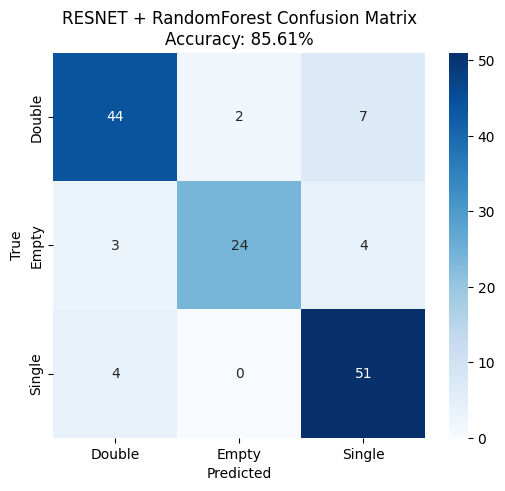

In [ ]:
# üö© Install dependencies (if not installed)
!pip install transformers tensorflow scikit-learn opencv-python matplotlib seaborn --quiet

# üö© Imports
from transformers import ViTFeatureExtractor, ViTModel
import torch
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV3Large
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.models import Model

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from google.colab import drive

# üö© Mount Google Drive
drive.mount('/content/drive')

# üö© Dataset Path (update with your folder)
dataset_path = '/content/drive/MyDrive/100_4strain_val_photos'

# üö© Load Dataset
img_size = (224, 224)
X, y = [], []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            label = os.path.basename(root)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)

print("Total images:", len(X))
print("Classes:", np.unique(y))

# üö© Encode Labels and Split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# üö© Feature Extraction Functions
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

def extract_vit_features(X_data):
    inputs = vit_feature_extractor(images=[cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in X_data], return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

def extract_features(model_name, X_data):
    if model_name == 'resnet':
        base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
        X_data = resnet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
        X_data = vgg_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'mobilenet':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, pooling='avg')
        X_data = mobilenet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vit':
        features = extract_vit_features(X_data)
    else:
        raise ValueError("Invalid model name")
    return features

# üö© Folder to save confusion matrices
save_folder = '/content/drive/MyDrive/confusion_matrices'
os.makedirs(save_folder, exist_ok=True)

# üö© üî• Choose the model: 'resnet' | 'vgg16' | 'mobilenet' | 'vit'
model_choice = 'resnet'  # Change to 'vgg16', 'mobilenet', or 'vit' as needed

print(f"\nExtracting features using {model_choice.upper()}...")
train_features = extract_features(model_choice, X_train)
val_features = extract_features(model_choice, X_val)

# üö© Classifiers
classifiers = {
    "SVM": SVC(kernel='linear', probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# üö© Training and Confusion Matrix Generation
for clf_name, clf in classifiers.items():
    print(f"\nTraining {clf_name} with {model_choice.upper()} features...")
    clf.fit(train_features, y_train)
    y_pred = clf.predict(val_features)

    acc = accuracy_score(y_val, y_pred)
    print(f"{clf_name} Accuracy: {acc*100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'{model_choice.upper()} + {clf_name} Confusion Matrix\nAccuracy: {acc*100:.2f}%')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save confusion matrix image
    filename = f'{model_choice.upper()}_{clf_name}_confusion_matrix.png'
    save_path = os.path.join(save_folder, filename)
    plt.savefig(save_path, bbox_inches='tight')
    print(f"‚úÖ Confusion matrix saved to {save_path}")

    plt.show()


In [ ]:
Finall

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images: 693
Classes: ['Double' 'Empty' 'Single']


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(



Extracting features using RESNET...
5/5 [==============================] - 31s 6s/step

Training SVM with RESNET features...
‚úÖ SVM Accuracy: 89.21% | Precision: 0.89 | Recall: 0.88 | F1: 0.88
üìä Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/RESNET_SVM_confusion_matrix.png


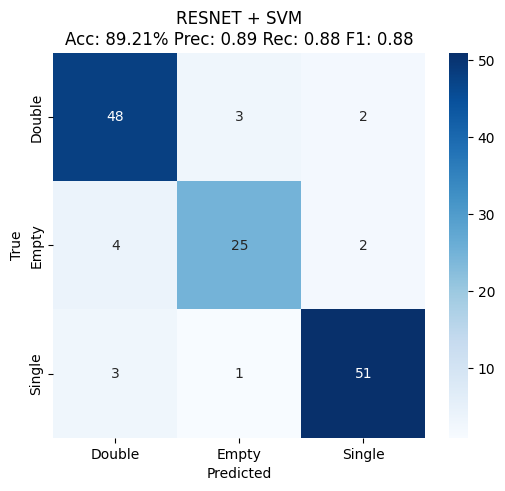


Confusion Matrix:
 [[48  3  2]
 [ 4 25  2]
 [ 3  1 51]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.87      0.91      0.89        53
       Empty       0.86      0.81      0.83        31
      Single       0.93      0.93      0.93        55

    accuracy                           0.89       139
   macro avg       0.89      0.88      0.88       139
weighted avg       0.89      0.89      0.89       139


Training MLP with RESNET features...
‚úÖ MLP Accuracy: 92.81% | Precision: 0.92 | Recall: 0.92 | F1: 0.92
üìä Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/RESNET_MLP_confusion_matrix.png


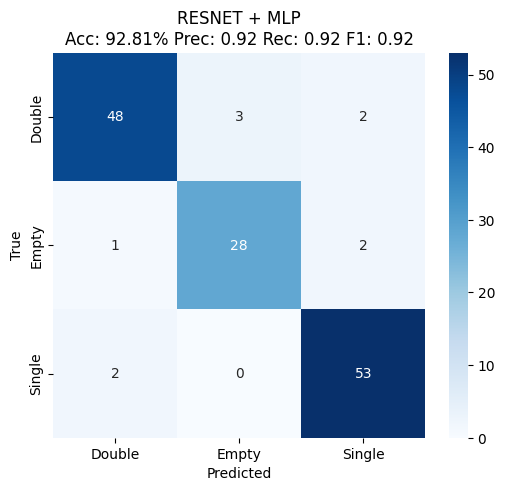


Confusion Matrix:
 [[48  3  2]
 [ 1 28  2]
 [ 2  0 53]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.94      0.91      0.92        53
       Empty       0.90      0.90      0.90        31
      Single       0.93      0.96      0.95        55

    accuracy                           0.93       139
   macro avg       0.92      0.92      0.92       139
weighted avg       0.93      0.93      0.93       139


Training RandomForest with RESNET features...
‚úÖ RandomForest Accuracy: 85.61% | Precision: 0.87 | Recall: 0.84 | F1: 0.85
üìä Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/RESNET_RandomForest_confusion_matrix.png


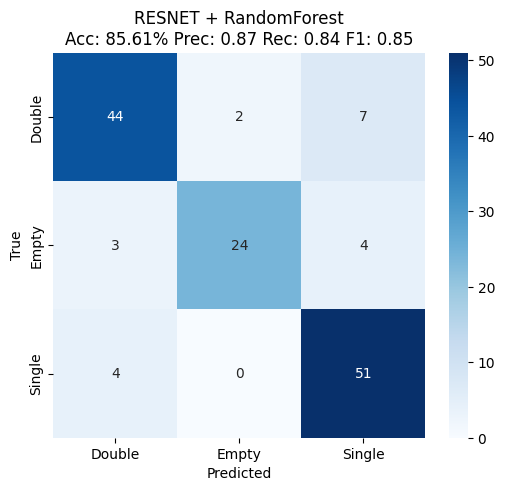


Confusion Matrix:
 [[44  2  7]
 [ 3 24  4]
 [ 4  0 51]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.86      0.83      0.85        53
       Empty       0.92      0.77      0.84        31
      Single       0.82      0.93      0.87        55

    accuracy                           0.86       139
   macro avg       0.87      0.84      0.85       139
weighted avg       0.86      0.86      0.86       139


üîç Metrics Summary:

    Model    Classifier  Accuracy  Precision    Recall  F1-Score
0  RESNET           SVM  0.892086   0.887356  0.879795  0.883165
1  RESNET           MLP  0.928058   0.924742  0.924174  0.924244
2  RESNET  RandomForest  0.856115   0.869468  0.843885  0.853351

‚úÖ Metrics summary CSV saved to /content/drive/MyDrive/confusion_matrices/RESNET_metrics_summary.csv


In [ ]:
# üö© Install dependencies
!pip install transformers tensorflow scikit-learn opencv-python matplotlib seaborn --quiet

# üö© Imports
from transformers import ViTFeatureExtractor, ViTModel
import torch
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV3Large
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.models import Model

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, classification_report)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import cv2
from google.colab import drive

# üö© Mount Google Drive
drive.mount('/content/drive')

# üö© Dataset Path (update path)
dataset_path = '/content/drive/MyDrive/100_4strain_val_photos'

# üö© Load Dataset
img_size = (224, 224)
X, y = [], []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            label = os.path.basename(root)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)

print("Total images:", len(X))
print("Classes:", np.unique(y))

# üö© Encode Labels and Split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# üö© Feature Extraction Functions
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

def extract_vit_features(X_data):
    inputs = vit_feature_extractor(images=[cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in X_data], return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

def extract_features(model_name, X_data):
    if model_name == 'resnet':
        base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
        X_data = resnet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
        X_data = vgg_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'mobilenet':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, pooling='avg')
        X_data = mobilenet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vit':
        features = extract_vit_features(X_data)
    else:
        raise ValueError("Invalid model name")
    return features

# üö© Folder to save confusion matrices
save_folder = '/content/drive/MyDrive/confusion_matrices'
os.makedirs(save_folder, exist_ok=True)

# üö© üî• Choose the model: 'resnet' | 'vgg16' | 'mobilenet' | 'vit'
model_choice = 'resnet'  # Change to 'vgg16', 'mobilenet', or 'vit' as needed

print(f"\nExtracting features using {model_choice.upper()}...")
train_features = extract_features(model_choice, X_train)
val_features = extract_features(model_choice, X_val)

# üö© Classifiers
classifiers = {
    "SVM": SVC(kernel='linear', probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# üö© DataFrame to store metrics
metrics_list = []

# üö© Training and Confusion Matrix Generation
for clf_name, clf in classifiers.items():
    print(f"\nTraining {clf_name} with {model_choice.upper()} features...")
    clf.fit(train_features, y_train)
    y_pred = clf.predict(val_features)

    # üö© Metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)

    print(f"‚úÖ {clf_name} Accuracy: {acc*100:.2f}% | Precision: {prec:.2f} | Recall: {rec:.2f} | F1: {f1:.2f}")

    #  Save metrics
    metrics_list.append({
        'Model': model_choice.upper(),
        'Classifier': clf_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    #  Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'{model_choice.upper()} + {clf_name}\nAcc: {acc*100:.2f}% Prec: {prec:.2f} Rec: {rec:.2f} F1: {f1:.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # üö© Save confusion matrix image
    filename = f'{model_choice.upper()}_{clf_name}_confusion_matrix.png'
    save_path = os.path.join(save_folder, filename)
    plt.savefig(save_path, bbox_inches='tight')
    print(f"üìä Confusion matrix saved to {save_path}")

    plt.show()

    # üö© Print confusion matrix numbers
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=label_encoder.classes_))

# üö© Metrics Summary DataFrame
metrics_df = pd.DataFrame(metrics_list)
print("\nüîç Metrics Summary:\n")
print(metrics_df)

# üö© Save metrics summary as CSV
metrics_csv_path = os.path.join(save_folder, f'{model_choice.upper()}_metrics_summary.csv')
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\n‚úÖ Metrics summary CSV saved to {metrics_csv_path}")


In [ ]:
mobilenet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images: 693
Classes: ['Double' 'Empty' 'Single']


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(



Extracting features using MOBILENET...
18/18 [==============================] - 25s 1s/step


5/5 [==============================] - 9s 1s/step

Training SVM with MOBILENET features...
‚úÖ SVM Accuracy: 90.65% | Precision: 0.91 | Recall: 0.90 | F1: 0.90
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/MOBILENET_SVM_confusion_matrix.png


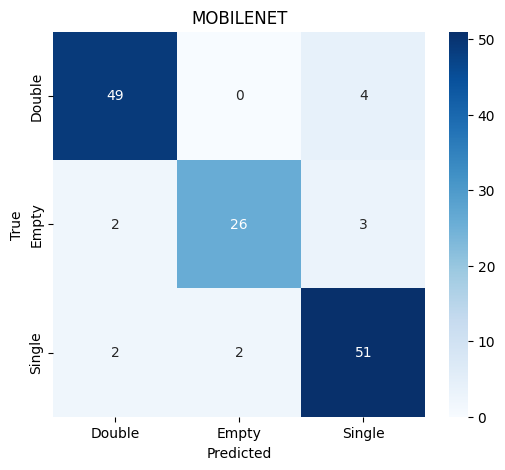


Confusion Matrix:
 [[49  0  4]
 [ 2 26  3]
 [ 2  2 51]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.92      0.92      0.92        53
       Empty       0.93      0.84      0.88        31
      Single       0.88      0.93      0.90        55

    accuracy                           0.91       139
   macro avg       0.91      0.90      0.90       139
weighted avg       0.91      0.91      0.91       139


Training MLP with MOBILENET features...
‚úÖ MLP Accuracy: 91.37% | Precision: 0.91 | Recall: 0.91 | F1: 0.91
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/MOBILENET_MLP_confusion_matrix.png


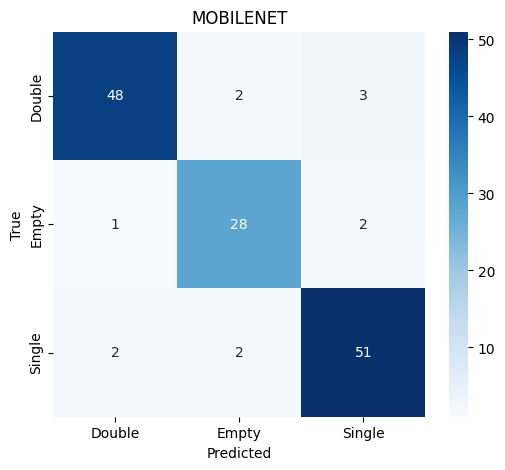


Confusion Matrix:
 [[48  2  3]
 [ 1 28  2]
 [ 2  2 51]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.94      0.91      0.92        53
       Empty       0.88      0.90      0.89        31
      Single       0.91      0.93      0.92        55

    accuracy                           0.91       139
   macro avg       0.91      0.91      0.91       139
weighted avg       0.91      0.91      0.91       139


Training RandomForest with MOBILENET features...
‚úÖ RandomForest Accuracy: 80.58% | Precision: 0.80 | Recall: 0.78 | F1: 0.79
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/MOBILENET_RandomForest_confusion_matrix.png


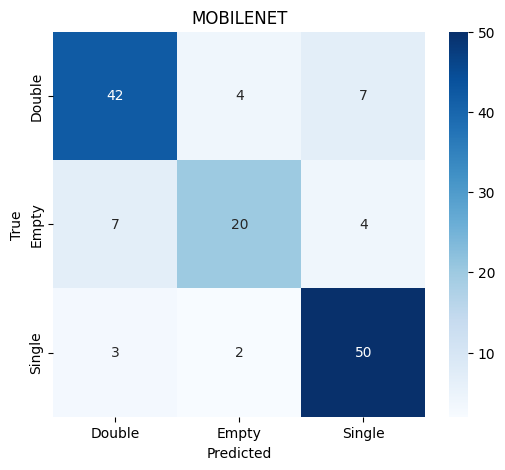


Confusion Matrix:
 [[42  4  7]
 [ 7 20  4]
 [ 3  2 50]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.81      0.79      0.80        53
       Empty       0.77      0.65      0.70        31
      Single       0.82      0.91      0.86        55

    accuracy                           0.81       139
   macro avg       0.80      0.78      0.79       139
weighted avg       0.80      0.81      0.80       139


 Metrics Summary:

       Model    Classifier  Accuracy  Precision    Recall  F1-Score
0  MOBILENET           SVM  0.906475   0.910803  0.896837  0.902846
1  MOBILENET           MLP  0.913669   0.908964  0.912053  0.910295
2  MOBILENET  RandomForest  0.805755   0.798865  0.782235  0.787941

 Metrics summary CSV saved to /content/drive/MyDrive/confusion_matrices/MOBILENET_metrics_summary.csv


In [ ]:
#  Install dependencies
!pip install transformers tensorflow scikit-learn opencv-python matplotlib seaborn --quiet

# Imports
from transformers import ViTFeatureExtractor, ViTModel
import torch
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV3Large
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.models import Model

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, classification_report)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import cv2
from google.colab import drive

#  Mount Google Drive
drive.mount('/content/drive')

#  Dataset Path
dataset_path = '/content/drive/MyDrive/100_4strain_val_photos'

#  Load Dataset
img_size = (224, 224)
X, y = [], []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            label = os.path.basename(root)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)

print("Total images:", len(X))
print("Classes:", np.unique(y))

#  Encode Labels and Split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

#  Feature Extraction Functions
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

def extract_vit_features(X_data):
    inputs = vit_feature_extractor(images=[cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in X_data], return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

def extract_features(model_name, X_data):
    if model_name == 'resnet':
        base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
        X_data = resnet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
        X_data = vgg_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'mobilenet':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, pooling='avg')
        X_data = mobilenet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vit':
        features = extract_vit_features(X_data)
    else:
        raise ValueError("Invalid model name")
    return features

#  Folder to save confusion matrices
save_folder = '/content/drive/MyDrive/confusion_matrices'
os.makedirs(save_folder, exist_ok=True)

#  Choose the model: 'resnet' | 'vgg16' | 'mobilenet' | 'vit'
#model_choice = 'resnet'  # Change to 'vgg16', 'mobilenet', or 'vit' as needed
#model_choice = 'vgg16'
model_choice = 'mobilenet'
#model_choice = 'vit'

print(f"\nExtracting features using {model_choice.upper()}...")
train_features = extract_features(model_choice, X_train)
val_features = extract_features(model_choice, X_val)

#  Classifiers
classifiers = {
    "SVM": SVC(kernel='linear', probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# DataFrame to store metrics
metrics_list = []

#Training and Confusion Matrix Generation
for clf_name, clf in classifiers.items():
    print(f"\nTraining {clf_name} with {model_choice.upper()} features...")
    clf.fit(train_features, y_train)
    y_pred = clf.predict(val_features)

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)

    print(f"{clf_name} Accuracy: {acc*100:.2f}% | Precision: {prec:.2f} | Recall: {rec:.2f} | F1: {f1:.2f}")

    #  Save metrics
    metrics_list.append({
        'Model': model_choice.upper(),
        'Classifier': clf_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    #  Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'{model_choice.upper()}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    #  Save confusion matrix image
    filename = f'{model_choice.upper()}_{clf_name}_confusion_matrix.png'
    save_path = os.path.join(save_folder, filename)
    plt.savefig(save_path, bbox_inches='tight')
    print(f" Confusion matrix saved to {save_path}")

    plt.show()

    #  Print confusion matrix numbers
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=label_encoder.classes_))

#  Metrics Summary DataFrame
metrics_df = pd.DataFrame(metrics_list)
print("\n Metrics Summary:\n")
print(metrics_df)

#Save metrics summary as CSV
metrics_csv_path = os.path.join(save_folder, f'{model_choice.upper()}_metrics_summary.csv')
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\n Metrics summary CSV saved to {metrics_csv_path}")


In [ ]:
vit

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images: 693
Classes: ['Double' 'Empty' 'Single']


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(



Extracting features using VIT...

Training SVM with VIT features...
‚úÖ SVM Accuracy: 88.49% | Precision: 0.89 | Recall: 0.86 | F1: 0.87
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/VIT_SVM_confusion_matrix.png


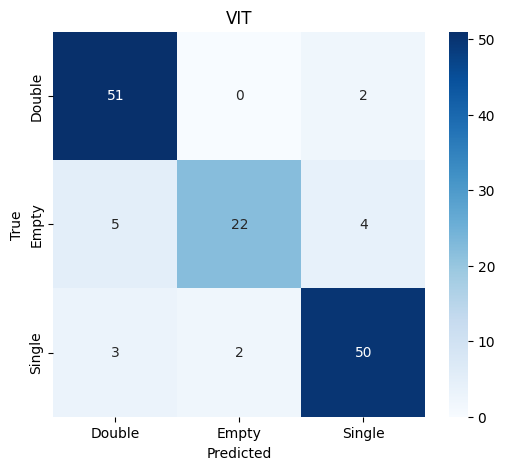


Confusion Matrix:
 [[51  0  2]
 [ 5 22  4]
 [ 3  2 50]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.86      0.96      0.91        53
       Empty       0.92      0.71      0.80        31
      Single       0.89      0.91      0.90        55

    accuracy                           0.88       139
   macro avg       0.89      0.86      0.87       139
weighted avg       0.89      0.88      0.88       139


Training MLP with VIT features...
‚úÖ MLP Accuracy: 87.05% | Precision: 0.87 | Recall: 0.85 | F1: 0.85
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/VIT_MLP_confusion_matrix.png


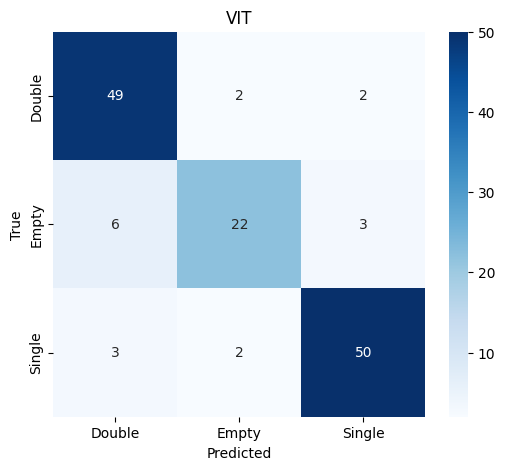


Confusion Matrix:
 [[49  2  2]
 [ 6 22  3]
 [ 3  2 50]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.84      0.92      0.88        53
       Empty       0.85      0.71      0.77        31
      Single       0.91      0.91      0.91        55

    accuracy                           0.87       139
   macro avg       0.87      0.85      0.85       139
weighted avg       0.87      0.87      0.87       139


Training RandomForest with VIT features...
‚úÖ RandomForest Accuracy: 82.01% | Precision: 0.84 | Recall: 0.79 | F1: 0.80
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/VIT_RandomForest_confusion_matrix.png


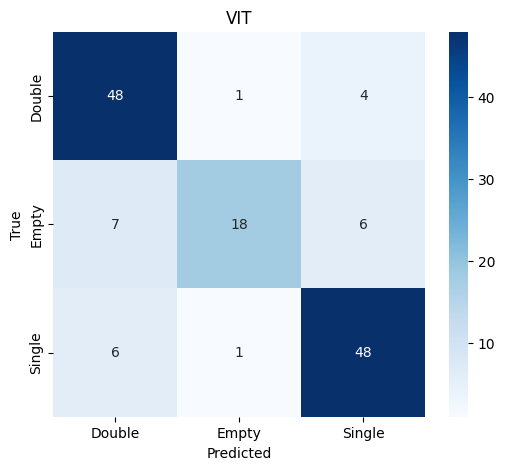


Confusion Matrix:
 [[48  1  4]
 [ 7 18  6]
 [ 6  1 48]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.79      0.91      0.84        53
       Empty       0.90      0.58      0.71        31
      Single       0.83      0.87      0.85        55

    accuracy                           0.82       139
   macro avg       0.84      0.79      0.80       139
weighted avg       0.83      0.82      0.81       139


 Metrics Summary:

  Model    Classifier  Accuracy  Precision    Recall  F1-Score
0   VIT           SVM  0.884892   0.891310  0.860344  0.870538
1   VIT           MLP  0.870504   0.866691  0.847766  0.854635
2   VIT  RandomForest  0.820144   0.838157  0.786344  0.799182

 Metrics summary CSV saved to /content/drive/MyDrive/confusion_matrices/VIT_metrics_summary.csv


In [ ]:
#  Install dependencies
!pip install transformers tensorflow scikit-learn opencv-python matplotlib seaborn --quiet

# Imports
from transformers import ViTFeatureExtractor, ViTModel
import torch
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV3Large
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.models import Model

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, classification_report)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import cv2
from google.colab import drive

#  Mount Google Drive
drive.mount('/content/drive')

#  Dataset Path
dataset_path = '/content/drive/MyDrive/100_4strain_val_photos'

# üö© Load Dataset
img_size = (224, 224)
X, y = [], []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            label = os.path.basename(root)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)

print("Total images:", len(X))
print("Classes:", np.unique(y))

#  Encode Labels and Split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

#  Feature Extraction Functions
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

def extract_vit_features(X_data):
    inputs = vit_feature_extractor(images=[cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in X_data], return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

def extract_features(model_name, X_data):
    if model_name == 'resnet':
        base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
        X_data = resnet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
        X_data = vgg_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'mobilenet':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, pooling='avg')
        X_data = mobilenet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vit':
        features = extract_vit_features(X_data)
    else:
        raise ValueError("Invalid model name")
    return features

#  Folder to save confusion matrices
save_folder = '/content/drive/MyDrive/confusion_matrices'
os.makedirs(save_folder, exist_ok=True)

#  Choose the model: 'resnet' | 'vgg16' | 'mobilenet' | 'vit'
#model_choice = 'resnet'  # Change to 'vgg16', 'mobilenet', or 'vit' as needed
#model_choice = 'vgg16'
#model_choice = 'mobilenet'
model_choice = 'vit'

print(f"\nExtracting features using {model_choice.upper()}...")
train_features = extract_features(model_choice, X_train)
val_features = extract_features(model_choice, X_val)

#  Classifiers
classifiers = {
    "SVM": SVC(kernel='linear', probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# DataFrame to store metrics
metrics_list = []

#Training and Confusion Matrix Generation
for clf_name, clf in classifiers.items():
    print(f"\nTraining {clf_name} with {model_choice.upper()} features...")
    clf.fit(train_features, y_train)
    y_pred = clf.predict(val_features)

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)

    print(f"‚úÖ {clf_name} Accuracy: {acc*100:.2f}% | Precision: {prec:.2f} | Recall: {rec:.2f} | F1: {f1:.2f}")

    #  Save metrics
    metrics_list.append({
        'Model': model_choice.upper(),
        'Classifier': clf_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    #  Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'{model_choice.upper()}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    #  Save confusion matrix image
    filename = f'{model_choice.upper()}_{clf_name}_confusion_matrix.png'
    save_path = os.path.join(save_folder, filename)
    plt.savefig(save_path, bbox_inches='tight')
    print(f" Confusion matrix saved to {save_path}")

    plt.show()

    #  Print confusion matrix numbers
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=label_encoder.classes_))

#  Metrics Summary DataFrame
metrics_df = pd.DataFrame(metrics_list)
print("\n Metrics Summary:\n")
print(metrics_df)

#Save metrics summary as CSV
metrics_csv_path = os.path.join(save_folder, f'{model_choice.upper()}_metrics_summary.csv')
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\n Metrics summary CSV saved to {metrics_csv_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images: 693
Classes: ['Double' 'Empty' 'Single']


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(



Extracting features using VGG16...
5/5 [==============================] - 84s 16s/step

Training SVM with VGG16 features...
 SVM Accuracy: 85.61% | Precision: 0.87 | Recall: 0.83 | F1: 0.84
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/VGG16_SVM_confusion_matrix.png


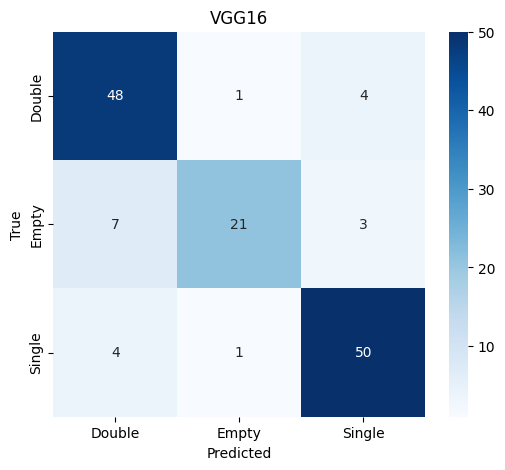


Confusion Matrix:
 [[48  1  4]
 [ 7 21  3]
 [ 4  1 50]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.81      0.91      0.86        53
       Empty       0.91      0.68      0.78        31
      Single       0.88      0.91      0.89        55

    accuracy                           0.86       139
   macro avg       0.87      0.83      0.84       139
weighted avg       0.86      0.86      0.85       139


Training MLP with VGG16 features...
 MLP Accuracy: 89.21% | Precision: 0.88 | Recall: 0.88 | F1: 0.88
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/VGG16_MLP_confusion_matrix.png


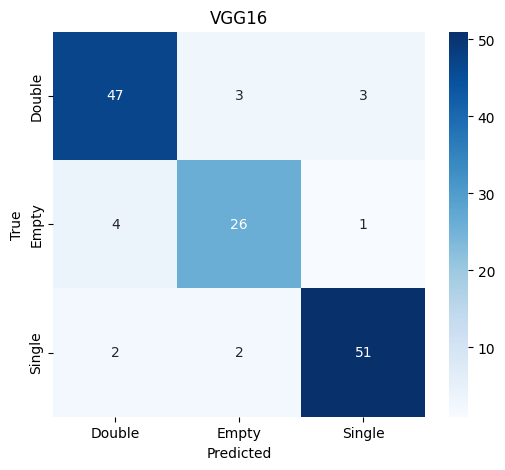


Confusion Matrix:
 [[47  3  3]
 [ 4 26  1]
 [ 2  2 51]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.89      0.89      0.89        53
       Empty       0.84      0.84      0.84        31
      Single       0.93      0.93      0.93        55

    accuracy                           0.89       139
   macro avg       0.88      0.88      0.88       139
weighted avg       0.89      0.89      0.89       139


Training RandomForest with VGG16 features...
 RandomForest Accuracy: 82.73% | Precision: 0.82 | Recall: 0.81 | F1: 0.82
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/VGG16_RandomForest_confusion_matrix.png


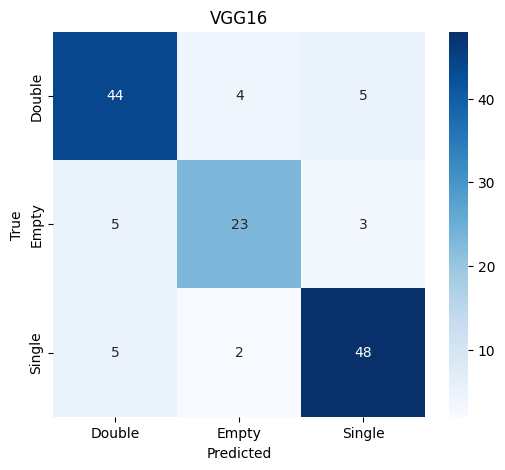


Confusion Matrix:
 [[44  4  5]
 [ 5 23  3]
 [ 5  2 48]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.81      0.83      0.82        53
       Empty       0.79      0.74      0.77        31
      Single       0.86      0.87      0.86        55

    accuracy                           0.83       139
   macro avg       0.82      0.81      0.82       139
weighted avg       0.83      0.83      0.83       139


 Metrics Summary:

   Model    Classifier  Accuracy  Precision    Recall  F1-Score
0  VGG16           SVM  0.856115   0.867932  0.830724  0.842593
1  VGG16           MLP  0.892086   0.884258  0.884258  0.884258
2  VGG16  RandomForest  0.827338   0.821687  0.814950  0.817987

 Metrics summary CSV saved to /content/drive/MyDrive/confusion_matrices/VGG16_metrics_summary.csv


In [ ]:
#  Install dependencies
!pip install transformers tensorflow scikit-learn opencv-python matplotlib seaborn --quiet

# Imports
from transformers import ViTFeatureExtractor, ViTModel
import torch
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV3Large
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.models import Model

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, classification_report)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import cv2
from google.colab import drive

#  Mount Google Drive
drive.mount('/content/drive')

#  Dataset Path
dataset_path = '/content/drive/MyDrive/100_4strain_val_photos'

# üö© Load Dataset
img_size = (224, 224)
X, y = [], []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            label = os.path.basename(root)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)

print("Total images:", len(X))
print("Classes:", np.unique(y))

#  Encode Labels and Split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

#  Feature Extraction Functions
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

def extract_vit_features(X_data):
    inputs = vit_feature_extractor(images=[cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in X_data], return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

def extract_features(model_name, X_data):
    if model_name == 'resnet':
        base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
        X_data = resnet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
        X_data = vgg_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'mobilenet':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, pooling='avg')
        X_data = mobilenet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vit':
        features = extract_vit_features(X_data)
    else:
        raise ValueError("Invalid model name")
    return features

#  Folder to save confusion matrices
save_folder = '/content/drive/MyDrive/confusion_matrices'
os.makedirs(save_folder, exist_ok=True)

#  Choose the model: 'resnet' | 'vgg16' | 'mobilenet' | 'vit'
#model_choice = 'resnet'  # Change to 'vgg16', 'mobilenet', or 'vit' as needed
model_choice = 'vgg16'
#model_choice = 'mobilenet'
#model_choice = 'vit'

print(f"\nExtracting features using {model_choice.upper()}...")
train_features = extract_features(model_choice, X_train)
val_features = extract_features(model_choice, X_val)

#  Classifiers
classifiers = {
    "SVM": SVC(kernel='linear', probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# DataFrame to store metrics
metrics_list = []

#Training and Confusion Matrix Generation
for clf_name, clf in classifiers.items():
    print(f"\nTraining {clf_name} with {model_choice.upper()} features...")
    clf.fit(train_features, y_train)
    y_pred = clf.predict(val_features)

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)

    print(f" {clf_name} Accuracy: {acc*100:.2f}% | Precision: {prec:.2f} | Recall: {rec:.2f} | F1: {f1:.2f}")

    #  Save metrics
    metrics_list.append({
        'Model': model_choice.upper(),
        'Classifier': clf_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    #  Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'{model_choice.upper()}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    #  Save confusion matrix image
    filename = f'{model_choice.upper()}_{clf_name}_confusion_matrix.png'
    save_path = os.path.join(save_folder, filename)
    plt.savefig(save_path, bbox_inches='tight')
    print(f" Confusion matrix saved to {save_path}")

    plt.show()

    #  Print confusion matrix numbers
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=label_encoder.classes_))

#  Metrics Summary DataFrame
metrics_df = pd.DataFrame(metrics_list)
print("\n Metrics Summary:\n")
print(metrics_df)

#Save metrics summary as CSV
metrics_csv_path = os.path.join(save_folder, f'{model_choice.upper()}_metrics_summary.csv')
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\n Metrics summary CSV saved to {metrics_csv_path}")


In [ ]:
graph

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images: 693
Classes: ['Double' 'Empty' 'Single']


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(



Extracting features using RESNET...
5/5 [==============================] - 31s 5s/step

Training SVM with RESNET features...
 SVM Accuracy: 89.21% | Precision: 0.89 | Recall: 0.88 | F1: 0.88
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/RESNET_SVM_confusion_matrix.png


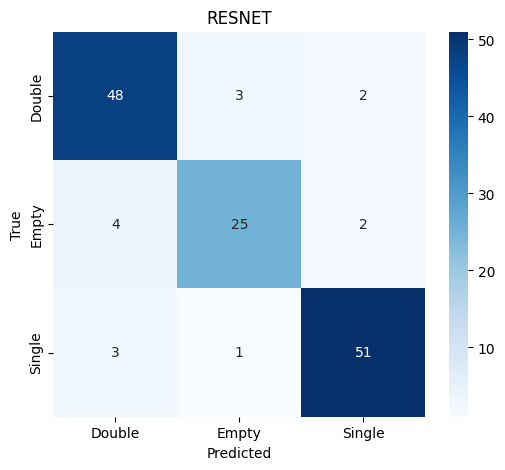


Confusion Matrix:
 [[48  3  2]
 [ 4 25  2]
 [ 3  1 51]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.87      0.91      0.89        53
       Empty       0.86      0.81      0.83        31
      Single       0.93      0.93      0.93        55

    accuracy                           0.89       139
   macro avg       0.89      0.88      0.88       139
weighted avg       0.89      0.89      0.89       139


Training MLP with RESNET features...
 MLP Accuracy: 91.37% | Precision: 0.91 | Recall: 0.91 | F1: 0.91
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/RESNET_MLP_confusion_matrix.png


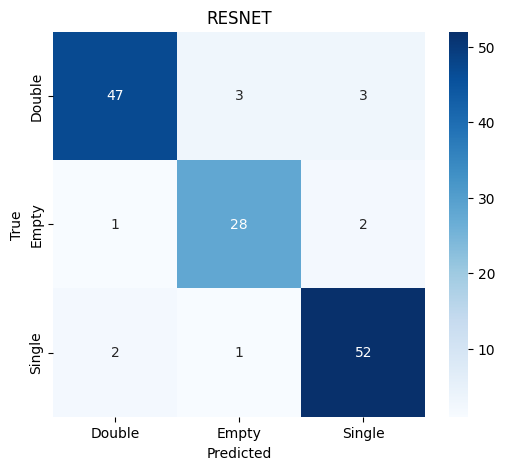


Confusion Matrix:
 [[47  3  3]
 [ 1 28  2]
 [ 2  1 52]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.94      0.89      0.91        53
       Empty       0.88      0.90      0.89        31
      Single       0.91      0.95      0.93        55

    accuracy                           0.91       139
   macro avg       0.91      0.91      0.91       139
weighted avg       0.91      0.91      0.91       139


Training RandomForest with RESNET features...
 RandomForest Accuracy: 85.61% | Precision: 0.87 | Recall: 0.84 | F1: 0.85
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/RESNET_RandomForest_confusion_matrix.png


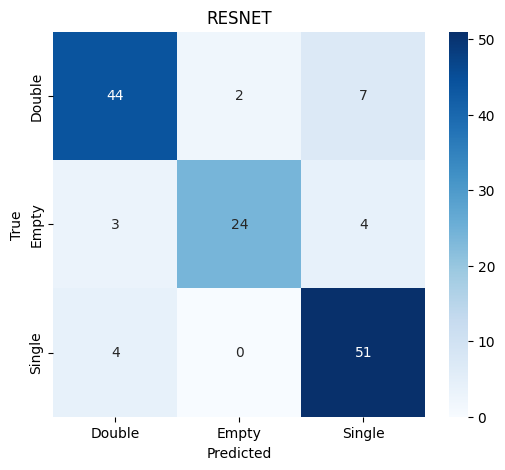


Confusion Matrix:
 [[44  2  7]
 [ 3 24  4]
 [ 4  0 51]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.86      0.83      0.85        53
       Empty       0.92      0.77      0.84        31
      Single       0.82      0.93      0.87        55

    accuracy                           0.86       139
   macro avg       0.87      0.84      0.85       139
weighted avg       0.86      0.86      0.86       139


 Metrics Summary:

    Model    Classifier  Accuracy  Precision    Recall  F1-Score
0  RESNET           SVM  0.892086   0.887356  0.879795  0.883165
1  RESNET           MLP  0.913669   0.909094  0.911824  0.910027
2  RESNET  RandomForest  0.856115   0.869468  0.843885  0.853351

 Metrics summary CSV saved to /content/drive/MyDrive/confusion_matrices/RESNET_metrics_summary.csv


In [ ]:
#  Install dependencies
!pip install transformers tensorflow scikit-learn opencv-python matplotlib seaborn --quiet

# Imports
from transformers import ViTFeatureExtractor, ViTModel
import torch
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV3Large
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.models import Model

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, classification_report)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import cv2
from google.colab import drive
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

#  Mount Google Drive
drive.mount('/content/drive')

#  Dataset Path
dataset_path = '/content/drive/MyDrive/100_4strain_val_photos'

# üö© Load Dataset
img_size = (224, 224)
X, y = [], []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            label = os.path.basename(root)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)

print("Total images:", len(X))
print("Classes:", np.unique(y))

#  Encode Labels and Split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

#  Feature Extraction Functions
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')


# Convert labels to categorical for Keras
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

def create_mlp(input_shape, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Example usage inside your loop instead of sklearn MLP
if clf_name == "MLP":
    mlp_model = create_mlp(train_features.shape[1], len(label_encoder.classes_))
    history = mlp_model.fit(train_features, y_train_cat, epochs=50, batch_size=32,
                            validation_data=(val_features, y_val_cat), verbose=1)

    # Plot training history
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_choice.upper()} + MLP Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_choice.upper()} + MLP Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()
  # For evaluation, use mlp_model.predict to get y_pred
    y_pred_probs = mlp_model.predict(val_features)
    y_pred = np.argmax(y_pred_probs, axis=1)


def extract_vit_features(X_data):
    inputs = vit_feature_extractor(images=[cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in X_data], return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

def extract_features(model_name, X_data):
    if model_name == 'resnet':
        base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
        X_data = resnet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
        X_data = vgg_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'mobilenet':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, pooling='avg')
        X_data = mobilenet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vit':
        features = extract_vit_features(X_data)
    else:
        raise ValueError("Invalid model name")
    return features

#  Folder to save confusion matrices
save_folder = '/content/drive/MyDrive/confusion_matrices'
os.makedirs(save_folder, exist_ok=True)

#  Choose the model: 'resnet' | 'vgg16' | 'mobilenet' | 'vit'
model_choice = 'resnet'  # Change to 'vgg16', 'mobilenet', or 'vit' as needed
#model_choice = 'vgg16'
#model_choice = 'mobilenet'
#model_choice = 'vit'

print(f"\nExtracting features using {model_choice.upper()}...")
train_features = extract_features(model_choice, X_train)
val_features = extract_features(model_choice, X_val)

#  Classifiers
classifiers = {
    "SVM": SVC(kernel='linear', probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# DataFrame to store metrics
metrics_list = []

#Training and Confusion Matrix Generation
for clf_name, clf in classifiers.items():
    print(f"\nTraining {clf_name} with {model_choice.upper()} features...")
    clf.fit(train_features, y_train)
    y_pred = clf.predict(val_features)

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)

    print(f" {clf_name} Accuracy: {acc*100:.2f}% | Precision: {prec:.2f} | Recall: {rec:.2f} | F1: {f1:.2f}")

    #  Save metrics
    metrics_list.append({
        'Model': model_choice.upper(),
        'Classifier': clf_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    #  Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'{model_choice.upper()}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    #  Save confusion matrix image
    filename = f'{model_choice.upper()}_{clf_name}_confusion_matrix.png'
    save_path = os.path.join(save_folder, filename)
    plt.savefig(save_path, bbox_inches='tight')
    print(f" Confusion matrix saved to {save_path}")

    plt.show()

    #  Print confusion matrix numbers
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=label_encoder.classes_))

#  Metrics Summary DataFrame
metrics_df = pd.DataFrame(metrics_list)
print("\n Metrics Summary:\n")
print(metrics_df)

#Save metrics summary as CSV
metrics_csv_path = os.path.join(save_folder, f'{model_choice.upper()}_metrics_summary.csv')
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\n Metrics summary CSV saved to {metrics_csv_path}")
